In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression

import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

,date,kawa
0,2018-05-07,113.33
1,2018-05-08,112.25
2,2018-05-09,111.45
3,2018-05-10,112.20
4,2018-05-11,112.06
...,...,...
1255,2023-05-01,174.19
1256,2023-05-02,175.27
1257,2023-05-03,174.10
1258,2023-05-04,171.70


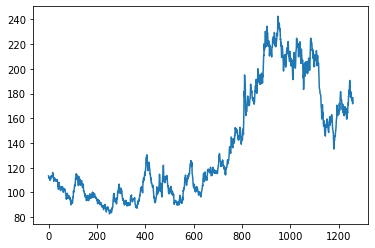

In [67]:
kawa = pd.read_csv('kawanowa.csv')
kawa
kawa.rename(columns={'value': 'kawa', 'date': 'date'}, inplace=True)
kawa = kawa[['date', 'kawa']]
kawa.dropna(inplace=True)
kawa = kawa[kawa['kawa'] > 0]
kawa['date'] = pd.to_datetime(kawa['date'], format='%d.%m.%Y')
kawa.sort_values(by='date', inplace=True)
kawa = kawa[kawa['kawa'] > 0]
kawa.reset_index(inplace=True, drop=True)
kawa
kawa['kawa'].plot()
kawa

In [68]:
olej = pd.read_csv('daneolej.csv')
olej
olej.rename(columns={'Close': 'olej', 'Date': 'date'}, inplace=True)
olej = olej[['olej', 'date']]
olej['date'] = pd.to_datetime(olej['date'])
olej.sort_values(by='date', inplace=True)
olej = olej[olej['olej'] > 0]
olej.reset_index(inplace=True, drop=True)
olej

,olej,date
0,2646,2017-07-25
1,2652,2017-07-26
2,2692,2017-07-27
3,2666,2017-07-28
4,2672,2017-07-31
...,...,...
1285,4327,2023-04-10
1286,4280,2023-04-11
1287,4170,2023-04-12
1288,4100,2023-04-13


,date,gsci
0,2018-05-07,653.83
1,2018-05-08,650.78
2,2018-05-09,655.94
3,2018-05-10,659.25
4,2018-05-11,655.84
...,...,...
1253,2023-04-27,978.14
1254,2023-04-28,989.24
1255,2023-05-01,982.50
1256,2023-05-02,965.50


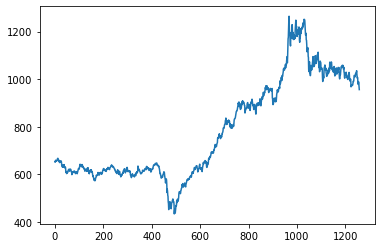

In [69]:
gsci = pd.read_csv('down.csv')
gsci
gsci.rename(columns={'value': 'gsci', 'date': 'date'}, inplace=True)
gsci = gsci[['date', 'gsci']]
gsci.dropna(inplace=True)
gsci = gsci[gsci['gsci'] > 0]
gsci['date'] = pd.to_datetime(gsci['date'], format='%d.%m.%Y')
gsci.sort_values(by='date', inplace=True)
gsci = gsci[gsci['gsci'] > 0]
gsci.reset_index(inplace=True, drop=True)
gsci
gsci['gsci'].plot()
gsci

In [70]:
results = kawa.merge(olej, on='date')
results = results.merge(gsci, on='date')
results

,date,kawa,olej,gsci
0,2018-05-07,113.33,2365,653.83
1,2018-05-08,112.25,2359,650.78
2,2018-05-15,109.76,2374,656.82
3,2018-05-16,110.09,2404,656.77
4,2018-05-17,110.65,2420,658.03
...,...,...,...,...
1076,2023-04-10,171.02,4327,1010.22
1077,2023-04-11,178.02,4280,1019.56
1078,2023-04-12,177.57,4170,1024.83
1079,2023-04-13,182.77,4100,1024.38


In [71]:

y_gaz = results['kawa']
y_ropa = results['olej']
y_usdpln = results['gsci']

In [72]:
df_final = pd.DataFrame()
df_final['Data'] = results['date']
df_final['przyrosty_log_gaz'] = np.log(y_gaz).diff()
df_final['przyrosty_log_ropa'] = np.log(y_ropa).diff()
df_final['przyrosty_log_usdpln'] = np.log(y_usdpln).diff()
df_final = df_final.dropna()

In [73]:
df_final = df_final.reset_index(drop=True)
df_final.head()

,Data,przyrosty_log_gaz,przyrosty_log_ropa,przyrosty_log_usdpln
0,2018-05-08,-0.009575,-0.002540,-0.004676
1,2018-05-15,-0.022432,0.006338,0.009238
2,2018-05-16,0.003002,0.012558,-0.000076
3,2018-05-17,0.005074,0.006634,0.001917
4,2018-05-18,0.000903,0.005358,0.000425


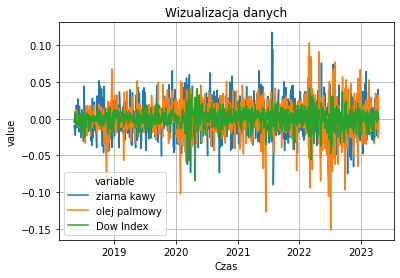

In [74]:
data_preproc = pd.DataFrame({
    'Data': df_final['Data'], 
    'ziarna kawy': df_final['przyrosty_log_gaz'],
    'olej palmowy': df_final['przyrosty_log_ropa'],
    'Dow Index': df_final['przyrosty_log_usdpln']})

sns.lineplot(x='Data', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Data']))
plt.title('Wizualizacja danych')
plt.xlabel('Czas')
plt.grid()
plt.show()

<AxesSubplot:>

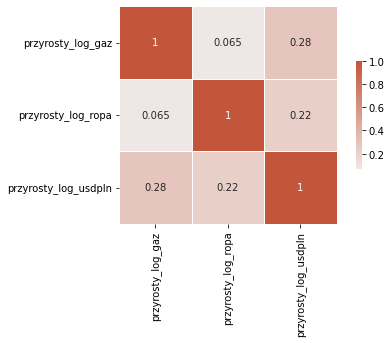

In [75]:
corr = df_final.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

<AxesSubplot:>

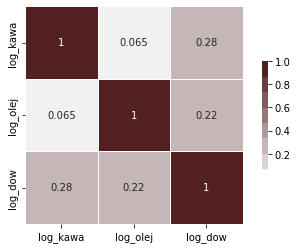

In [76]:
df_same = pd.DataFrame()
df_same['log_kawa'] = df_final['przyrosty_log_gaz']
df_same['log_olej'] = df_final['przyrosty_log_ropa']
df_same['log_dow'] = df_final['przyrosty_log_usdpln']

corr2 = df_same.corr()

f, ax = plt.subplots(figsize=(7, 4))


cmap = sns.diverging_palette(250, 10, n=15,s=50,l=20)
sns.heatmap(corr2, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

In [77]:
k = 1

df_moved = pd.DataFrame()
df_moved['przyrosty_log_gaz'] = df_final['przyrosty_log_gaz'][k:]
df_moved['przyrosty_log_ropa'] = df_final['przyrosty_log_ropa'][k:]
df_moved['przyrosty_log_usdpln'] = df_final['przyrosty_log_usdpln'][:-k]

<AxesSubplot:>

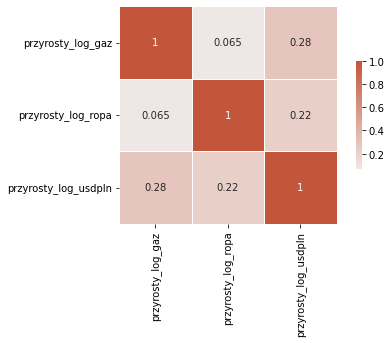

In [78]:
corr2 = df_moved.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr2, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

In [79]:
def jednowskaznikowy(R, Rs):
    lr = LinearRegression()

    lr.fit(np.expand_dims(Rs, axis=1), np.expand_dims(R, axis=1))

    beta, alpha= lr.coef_[0, 0], lr.intercept_[0]
    determinacja = beta **2 * np.var(Rs) / np.var(R)
    war_res = np.sum((R - alpha - beta * Rs) ** 2) / ( len(R) -1)
    
    nazwy = ['alpha kawa', 'beta kawa', 'Współczynnik determinacji', 'Wariancja residuów']
    wartości = [alpha, beta, determinacja, war_res]
    
    plt.scatter(Rs, R, color="#13C6EB")
    plt.plot([min(Rs), max(Rs)], [beta * min(Rs) + alpha, beta * max(Rs) + alpha], color="#F43D64")
    
    return pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})

,Parametr,Wartość
0,alpha kawa,0.000199
1,beta kawa,0.546786
2,Współczynnik determinacji,0.079763
3,Wariancja residuów,0.000471


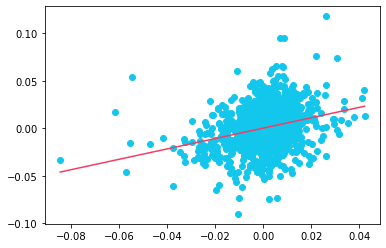

In [80]:
lr_gaz = jednowskaznikowy(df_final['przyrosty_log_gaz'], df_final['przyrosty_log_usdpln'])
lr_gaz

,Parametr,Wartość
0,alpha kawa,0.000322
1,beta kawa,0.449422
2,Współczynnik determinacji,0.049307
3,Wariancja residuów,0.000532


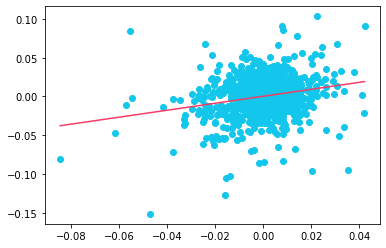

In [81]:
lr_ropa = jednowskaznikowy(df_final['przyrosty_log_ropa'], df_final['przyrosty_log_usdpln'])
lr_ropa

In [82]:
alpha_gaz = lr_gaz.iloc[0, 1]
beta_gaz = lr_gaz.iloc[1, 1]
alpha_ropa = lr_ropa.iloc[0, 1]
beta_ropa = lr_ropa.iloc[1, 1]

nazwy = ['alpha_gaz', 'beta_gaz', 'alpha_ropa', 'beta_ropa']
wartości = [alpha_gaz, beta_gaz, alpha_ropa, beta_ropa]
df_lr_coef = pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})
df_lr_coef

,Parametr,Wartość
0,alpha_gaz,0.000199
1,beta_gaz,0.546786
2,alpha_ropa,0.000322
3,beta_ropa,0.449422


In [83]:
# gaz
residua_gaz =  df_final['przyrosty_log_gaz'] - alpha_gaz - beta_gaz * df_final['przyrosty_log_usdpln']
a_gaz = alpha_gaz + residua_gaz

# ropa
residua_ropa =  df_final['przyrosty_log_ropa'] - alpha_ropa - beta_ropa * df_final['przyrosty_log_usdpln']
a_ropa = alpha_ropa + residua_ropa

In [84]:
st.pearsonr(df_final['przyrosty_log_usdpln'], residua_gaz)

(-1.0408340855860843e-16, 0.9999999999985855)

In [85]:
(residua_gaz*(df_final['przyrosty_log_usdpln'] - df_final['przyrosty_log_usdpln'].mean())).mean()

-1.6972030535725056e-20

In [86]:
st.pearsonr(df_final['przyrosty_log_usdpln'], residua_ropa)

(-4.163336342344337e-17, 0.999999999998657)

In [87]:
(residua_ropa*(df_final['przyrosty_log_usdpln'] - df_final['przyrosty_log_usdpln'].mean())).mean()

-2.3428303889241165e-20

In [88]:
st.pearsonr(residua_gaz, residua_ropa)

(0.0025635145369066192, 0.9329385515508617)

In [89]:
def mean_std_corr():
    
    nazwy = ['Średnia przyrostów gazu',
             'Średnia przyrostów ropy',
             'Odchylenie std przyrostów gazu',
             'Odchylenie std przyrostów ropy',
             'Współczynnik korelacji']
    
    wartosci = [alpha_gaz + beta_gaz*df_final['przyrosty_log_usdpln'].mean(),
                alpha_ropa + beta_ropa*df_final['przyrosty_log_usdpln'].mean(),
                np.var(residua_gaz) + beta_gaz**2 * np.var(df_final['przyrosty_log_usdpln']),
                np.var(residua_ropa) + beta_ropa**2 * np.var(df_final['przyrosty_log_usdpln']),
                beta_gaz*beta_ropa*np.var(df_final['przyrosty_log_usdpln'])]
    
    return pd.DataFrame({'Parametr':nazwy, 'Wartość': wartosci})

In [90]:
mean_std_corr()

,Parametr,Wartość
0,Średnia przyrostów gazu,0.000427
1,Średnia przyrostów ropy,0.000509
2,Odchylenie std przyrostów gazu,0.000512
3,Odchylenie std przyrostów ropy,0.000559
4,Współczynnik korelacji,0.000034


In [91]:
a=len(a_gaz + usd_przyrosty * beta_gaz)

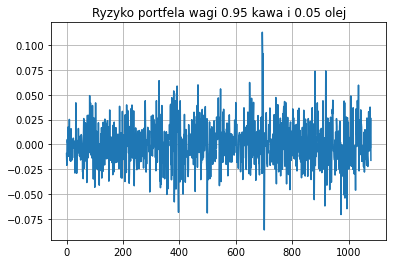

In [92]:
W1 = 0.95
W2 = 0.05

portfel = W1*(a_gaz + usd_przyrosty * beta_gaz) + W2*(a_ropa + usd_przyrosty* beta_ropa)
plt.plot(np.arange(0,a,1),portfel)
plt.title('Ryzyko portfela wagi 0.95 kawa i 0.05 olej')
plt.grid()

In [93]:
def covariance(x, y):

    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    
    return cov

In [94]:
k = np.arange(0,1,0.01)
wagi = []

for i in range(len(k)):
    wagi.append([k[i],1-k[i]])

In [95]:
space = np.linspace(0, 1, 100)
wagi = list(zip(space.round(decimals=2), (1-space).round(decimals=2)))
usd_przyrosty = df_final['przyrosty_log_usdpln']

In [96]:
portfele_residua = pd.DataFrame(index=["waga gaz", "waga ropa", "stopa zwrotu", "ryzyko"])

for waga_gaz, waga_ropa, in wagi:
    temp_portfel_residua = \
        waga_gaz*(a_gaz + usd_przyrosty * beta_gaz) + \
        waga_ropa*(a_ropa + usd_przyrosty* beta_ropa)
    
    portfele_residua[f"skóra: {waga_gaz}\nguma: {waga_ropa}"] = \
        [waga_gaz, 
         waga_ropa, 
         np.mean(temp_portfel_residua), 
         np.std(temp_portfel_residua, ddof=1)]
    

portfele_residua.head()

,skóra: 0.0\nguma: 1.0,skóra: 0.01\nguma: 0.99,skóra: 0.02\nguma: 0.98,skóra: 0.03\nguma: 0.97,skóra: 0.04\nguma: 0.96,skóra: 0.05\nguma: 0.95,skóra: 0.06\nguma: 0.94,skóra: 0.07\nguma: 0.93,skóra: 0.08\nguma: 0.92,skóra: 0.09\nguma: 0.91,...,skóra: 0.91\nguma: 0.09,skóra: 0.92\nguma: 0.08,skóra: 0.93\nguma: 0.07,skóra: 0.94\nguma: 0.06,skóra: 0.95\nguma: 0.05,skóra: 0.96\nguma: 0.04,skóra: 0.97\nguma: 0.03,skóra: 0.98\nguma: 0.02,skóra: 0.99\nguma: 0.01,skóra: 1.0\nguma: 0.0
waga gaz,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,...,0.910000,0.920000,0.930000,0.940000,0.950000,0.960000,0.970000,0.980000,0.990000,1.000000
waga ropa,1.000000,0.990000,0.980000,0.970000,0.960000,0.950000,0.940000,0.930000,0.920000,0.910000,...,0.090000,0.080000,0.070000,0.060000,0.050000,0.040000,0.030000,0.020000,0.010000,0.000000
stopa zwrotu,0.000509,0.000509,0.000508,0.000507,0.000506,0.000505,0.000505,0.000504,0.000503,0.000502,...,0.000434,0.000434,0.000433,0.000432,0.000431,0.000430,0.000429,0.000429,0.000428,0.000427
ryzyko,0.023658,0.023437,0.023218,0.023002,0.022788,0.022577,0.022368,0.022161,0.021957,0.021756,...,0.020841,0.021028,0.021218,0.021412,0.021608,0.021807,0.022009,0.022213,0.022420,0.022630


Text(0.5, 1.0, 'Portfele z różnymi wagami dla modelu jednowskaźnikowego')

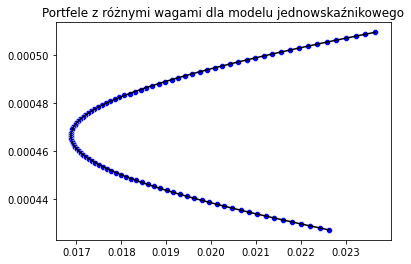

In [97]:
zwrot_residua = portfele_residua.iloc[2,:].values
ryzyko_residua = portfele_residua.iloc[3,:].values
sns.lineplot(x=ryzyko_residua, y=zwrot_residua, color = "black", sort=False)
sns.scatterplot(x=ryzyko_residua, y=zwrot_residua, color = "blue")
plt.title("Portfele z różnymi wagami dla modelu jednowskaźnikowego")

In [98]:
portfele_residua

,skóra: 0.0\nguma: 1.0,skóra: 0.01\nguma: 0.99,skóra: 0.02\nguma: 0.98,skóra: 0.03\nguma: 0.97,skóra: 0.04\nguma: 0.96,skóra: 0.05\nguma: 0.95,skóra: 0.06\nguma: 0.94,skóra: 0.07\nguma: 0.93,skóra: 0.08\nguma: 0.92,skóra: 0.09\nguma: 0.91,...,skóra: 0.91\nguma: 0.09,skóra: 0.92\nguma: 0.08,skóra: 0.93\nguma: 0.07,skóra: 0.94\nguma: 0.06,skóra: 0.95\nguma: 0.05,skóra: 0.96\nguma: 0.04,skóra: 0.97\nguma: 0.03,skóra: 0.98\nguma: 0.02,skóra: 0.99\nguma: 0.01,skóra: 1.0\nguma: 0.0
waga gaz,0.000000,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,...,0.910000,0.920000,0.930000,0.940000,0.950000,0.960000,0.970000,0.980000,0.990000,1.000000
waga ropa,1.000000,0.990000,0.980000,0.970000,0.960000,0.950000,0.940000,0.930000,0.920000,0.910000,...,0.090000,0.080000,0.070000,0.060000,0.050000,0.040000,0.030000,0.020000,0.010000,0.000000
stopa zwrotu,0.000509,0.000509,0.000508,0.000507,0.000506,0.000505,0.000505,0.000504,0.000503,0.000502,...,0.000434,0.000434,0.000433,0.000432,0.000431,0.000430,0.000429,0.000429,0.000428,0.000427
ryzyko,0.023658,0.023437,0.023218,0.023002,0.022788,0.022577,0.022368,0.022161,0.021957,0.021756,...,0.020841,0.021028,0.021218,0.021412,0.021608,0.021807,0.022009,0.022213,0.022420,0.022630


In [99]:
# szukam indeksu gdzie ryzyko jest najmniejsze
min_risk_idx = portfele_residua.iloc[3,:].values.argmin()
min_risk_idx

51

In [100]:
portfele_residua.iloc[3,:].values.min() # minimalne ryzyko, całkiem podobne do tego co wyszlo w 1 zadaniu

0.016876891545595896

In [101]:
# dla odsetku wagi ropy 0.71 0 wagi gazu 0.29 ryzyko jest najmnijesze, w zadaniu pierwszym
# u Adriana wyszło całkiem podobnie
min_risk = portfele_residua.iloc[:, min_risk_idx]
min_risk

waga gaz        0.520000
waga ropa       0.480000
stopa zwrotu    0.000467
ryzyko          0.016877
Name: skóra: 0.52\nguma: 0.48, dtype: float64

In [102]:
x = portfele_residua.iloc[1, min_risk_idx] # x - odsetek ropy
print("Odetek ropy",np.round((1 - x), 3)) 
print("Stosunek ropy do gazu 1:",np.round((1 - x)/x, 3), 
      "\nryzyko wynosi: ", np.round(portfele_residua.iloc[3, min_risk_idx], 4))

Odetek ropy 0.52
Stosunek ropy do gazu 1: 1.083 
ryzyko wynosi:  0.0169


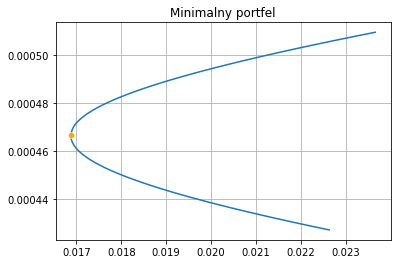

In [103]:
zwrot_residua = portfele_residua.iloc[2,:].values
ryzyko_residua = portfele_residua.iloc[3,:].values
odsetek_ropy = portfele_residua.iloc[1, :].values
sns.lineplot(x=ryzyko_residua, y=zwrot_residua, sort=False)
sns.scatterplot(x=[min_risk[3]], y=[min_risk[2]], color = "orange", zorder=2)
plt.title("Minimalny portfel")
plt.grid()

Text(0.5, 0, 'Ryzyko')

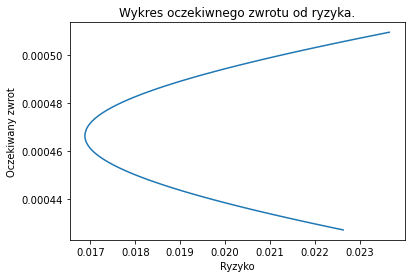

In [104]:
fig, ax = plt.subplots(1,1)
ax.plot(ryzyko_residua, zwrot_residua)
ax.set_title('Wykres oczekiwnego zwrotu od ryzyka.')
ax.set_ylabel('Oczekiwany zwrot')
ax.set_xlabel('Ryzyko')

In [105]:
min_risk

waga gaz        0.520000
waga ropa       0.480000
stopa zwrotu    0.000467
ryzyko          0.016877
Name: skóra: 0.52\nguma: 0.48, dtype: float64

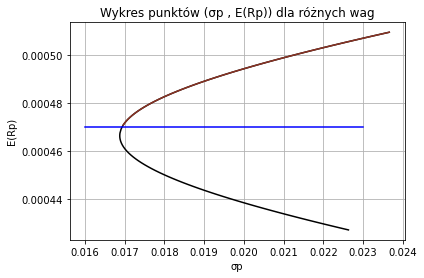

In [117]:
#d)
dane_sigma = ryzyko_residua
dane_srednia = zwrot_residua


dane1 = []
dane2 = []

for i in range(len(dane_srednia)):
    
    if dane_srednia[i] > 0.00047:
        dane1.append(dane_sigma[i])
        dane2.append(dane_srednia[i])



#minimalna wymagana stopa zwrotu
plt.plot(dane_sigma, dane_srednia, color='black')
plt.plot(dane1, dane2, color='#8A3324')
plt.title("Wykres punktów (σp , E(Rp)) dla różnych wag")
plt.xlabel('σp')
plt.ylabel('E(Rp)')
k = np.linspace(0.016,0.023,100)
plt.plot(k,0.00047*k/k,color = 'b')
plt.grid()
plt.savefig("dupa2.jpg");

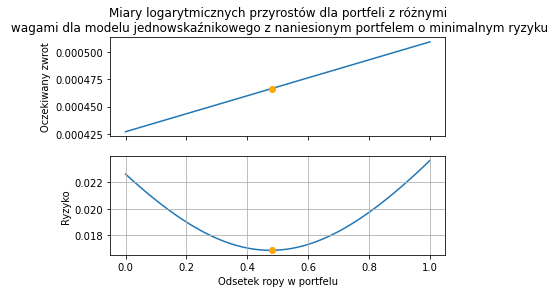

In [44]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(odsetek_ropy, zwrot_residua, zorder=1)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli z różnymi\n'
                 ' wagami dla modelu jednowskaźnikowego z naniesionym portfelem o minimalnym ryzyku')
axs[0].scatter(x=[min_risk[1]], y=[min_risk[2]], color="orange", zorder=2)

axs[1].plot(odsetek_ropy, ryzyko_residua, zorder=1)
axs[1].scatter(x=[min_risk[1]], y=[min_risk[3]], c="orange", alpha=1, zorder=2)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')
plt.grid()